# Xây dựng LeNet-5 model với Pytorch huấn luyện trên tập dữ liệu MNIST.

- MNIST là một dataset bao gồm 70000 ảnh số  viết tay từ 0 đến 9 có kích thước 28 x 28 pixels, thuộc dạng ảnh grayscale (tức là ảnh đen trắng(1 channel)).

- Dưới đây là ảnh một số mẫu input của dataset MNIST.
  
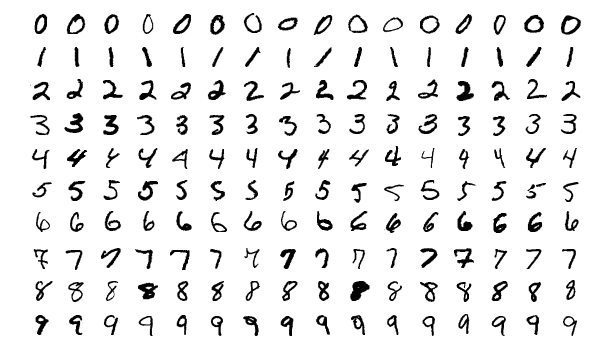

- Output bao gồm các Label: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

## Thực hiện bước chuẩn bị dữ liệu:
- Thực hiện bước **Data Augmentation**. 
- Bao gồm chia dữ liệu ra 3 tập **Train**, **Validaion** và **Test**.
- Trong đó, Train set có 48000 samples, Validation set có 12000 samples, và Test set có 10000

In [1]:
import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


transform_augmented = transforms.Compose([
    transforms.RandomAffine(
        degrees=10, # Góc xoay ảnh qua lại (qua trái hoặc qua phải 10 độ)
        translate = (0.1, 0.1), # Tịnh tiến ảnh lên xuống trái phải
        scale = (0.9, 1.1), # Tỉ lệ so với ảnh gốc
        shear = 10 # Độ nghiêng
    ), 
    transforms.ToTensor() # Chuyển sang tensor để sử dụng PyTorch
])

# Tải dữ liệu MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_augmented)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_augmented)


indices = list(range(len(train_dataset)))

train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=6969)

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)


# Tạo DataLoader
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=3)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=3)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=3)


# Kiểm tra kích thước
print(f"Train size: {len(train_subset)}, Validation size: {len(val_subset)} Test size: {len(test_dataset)}")

Train size: 48000, Validation size: 12000 Test size: 10000


## Mô tả dữ liệu
- Trainloader đang có dạng một tập các phần tử (input, label)
- Mỗi `inputs` nằm trong `trainloader` hoặc `testloader` đều có shape = (32, 1, 28, 28), kiểu torch, tức là batch=32, channel=1, height $\times$ weight = 28 $\times$ 28

### Visualizaion một số ảnh trong tập dữ liệu: 

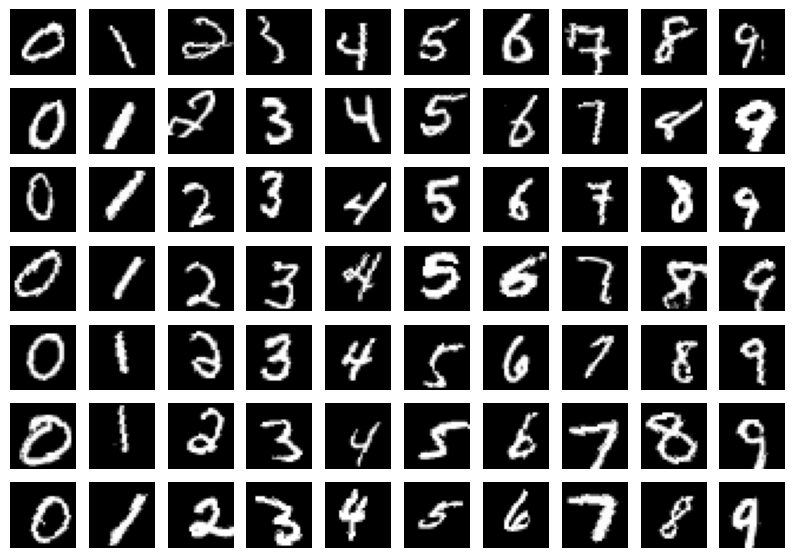

In [2]:
fig, axes = plt.subplots(7, 10, figsize=(10, 7))
j = 0

for i, ax in enumerate(axes.flat):
    image, label = train_subset[j]
    while label != i % 10:
        j += 1
        image, label = train_subset[j]

    ax.imshow(image[0], cmap='gray')
    # ax.set_title(label)
    ax.axis('off')

plt.show()

## Định nghĩa một LeNet-5 model nhận diện chữ viết

In [3]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # (32, 1, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=3, padding=1) # (32, 9, 28, 28)
        self.AvgPool1 = nn.AvgPool2d(kernel_size=2, stride=2) # (32, 9, 14, 14) 

        self.conv2 = nn.Conv2d(in_channels=9, out_channels=36, kernel_size=5) # (32, 36, 10, 10) 
        self.AvgPool2 = nn.AvgPool2d(kernel_size=2, stride=2) #(32, 36, 5, 5)

        self.conv3 = nn.Conv2d(in_channels=36, out_channels=72, kernel_size=2) # (32, 72, 4, 4)

        self.Flatten = nn.Flatten() # (32, 72, 4, 4) -> (32, 72*4*4)

        self.fc1 = nn.Linear(72*4*4, 96) # (32, 96)
        self.fc2 = nn.Linear(96, 10) # (32, 10)

        self.tanh = nn.Tanh()

    
    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.AvgPool1(x)
        x = self.tanh(self.conv2(x))
        x = self.AvgPool2(x)
        x = self.tanh(self.conv3(x))
        
        x = self.Flatten(x)
        x = self.tanh(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)

        return x

## Define `Early Stopping` function

In [4]:
class EarlyStopping():
    def __init__(self, patience=7, delta=0):
        self.patience = patience
        self.delta = delta
        
        self.counter = 0
        self.best_score = None # minimize val_loss
        self.early_stop = False
        self.best_model_state = None


    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model_state = model.state_dict()
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    
    
    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

## Define `Train_model()` function

In [5]:
def Train_model():
    model.train()
    total_loss = 0.0
    

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        predictions = model(inputs) # forward pass
        loss = loss_fn(predictions, labels)

        optimizer.zero_grad() # zero out the gradients
        loss.backward() # backpropagation
        optimizer.step()
        total_loss += loss.item()
    
    
    avg_loss = total_loss / len(trainloader)
    return avg_loss

## Define `Validate_model()` function

In [6]:
def Validate_model():
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad(): # Không tính gradient để tiết kiệm bộ nhớ & tăng tốc độ tính  toán.
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            predictions = model(inputs)
            loss = loss_fn(predictions, labels)
            
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(predictions, 1)
            correct_predictions += (predicted == labels).sum().item() # (TP + TN)
            total_samples += inputs.size(0) # (TP + TN + FP + FN)
    
    
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples # accuracy = (TP + TN) / (TP + TN + FP + FN)

    return avg_loss, accuracy

## Khởi tạo ***model, loss function, optimizer***, ***Early stopping*** và ***Learning rate schedule***

In [ ]:
device = torch.device('cuda:0')
model = LeNet5().to(device)

loss_fn = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer
early_stopping = EarlyStopping(patience=5, delta=0.00001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

## Train model

In [ ]:
num_epochs = 10000
trainloss_list = []
valloss_list = []
valaccuracy_list = []

for epoch in range(num_epochs):
    train_loss = Train_model()
    val_loss, val_accuracy = Validate_model()
    
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    trainloss_list.append(train_loss)
    valloss_list.append(val_loss)
    valaccuracy_list.append(val_accuracy)
    
    print(f"Epoch: {epoch + 1} / {num_epochs}, Average training loss: {train_loss:.9f},  Validation loss: {val_loss:.9f}, Validation accuracy: {val_accuracy:.9f}", end=', ')
    
    # In learning rate
    for param_group in optimizer.param_groups:
        print(f"Learning Rate = {param_group['lr']}")


early_stopping.load_best_model(model)
print("Done training")

Epoch: 1 / 10000, Average training loss: 1.734632113,  Validation loss: 1.581880605, Validation accuracy: 0.896083333, Learning Rate = 0.001
Epoch: 2 / 10000, Average training loss: 1.546317588,  Validation loss: 1.524636562, Validation accuracy: 0.943416667, Learning Rate = 0.001
Epoch: 3 / 10000, Average training loss: 1.522966003,  Validation loss: 1.521448884, Validation accuracy: 0.947166667, Learning Rate = 0.001
Epoch: 4 / 10000, Average training loss: 1.514986171,  Validation loss: 1.509130765, Validation accuracy: 0.956166667, Learning Rate = 0.001
Epoch: 5 / 10000, Average training loss: 1.509389264,  Validation loss: 1.506719433, Validation accuracy: 0.958083333, Learning Rate = 0.001
Epoch: 6 / 10000, Average training loss: 1.505276773,  Validation loss: 1.500232038, Validation accuracy: 0.963416667, Learning Rate = 0.001
Epoch: 7 / 10000, Average training loss: 1.503459670,  Validation loss: 1.505235865, Validation accuracy: 0.960416667, Learning Rate = 0.001
Epoch: 8 / 10

## Evaluate model

- Tính Accuracy, Confusion matrix, Classification report

In [ ]:
# Hàm tính accuracy, và đồng thời lưu predict và output khi model dự đoán trên tập test
def Evaludate_model(): 
    model.eval() 
    correct = 0
    total = 0

    output_labels = np.array([])
    predict_labels = np.array([])


    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)

            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()

            output_labels = np.append(output_labels, labels.cpu().numpy())
            predict_labels = np.append(predict_labels, predicted.cpu().numpy())


    return correct / total, output_labels, predict_labels

In [ ]:
accuracy, output_label, predict_label = Evaludate_model()        

# in ra accuracy
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

# in ra confusion matrix
cm = confusion_matrix(output_label, predict_label)
print('Confusion matrix:\n', cm)

# in ra classification report
report = classification_report(output_label, predict_label, target_names=["number " + str(i) for i in range(10)])
print('Classification report:\n', report)

Accuracy on test set: 98.53%
Confusion matrix:
 [[ 970    0    0    0    1    1    6    1    1    0]
 [   0 1125    2    2    0    0    3    2    1    0]
 [   0    1 1023    0    0    0    1    6    1    0]
 [   0    1    2  996    0    5    0    2    3    1]
 [   0    0    0    0  975    0    0    0    0    7]
 [   2    0    0    3    0  878    4    2    1    2]
 [   6    1    1    1    1    1  944    0    3    0]
 [   0    5    6    1    0    0    0 1010    2    4]
 [   1    1    5    2    1    4    1    3  950    6]
 [   1    3    1    3   14    1    0    2    2  982]]
Classification report:
               precision    recall  f1-score   support

    number 0       0.99      0.99      0.99       980
    number 1       0.99      0.99      0.99      1135
    number 2       0.98      0.99      0.99      1032
    number 3       0.99      0.99      0.99      1010
    number 4       0.98      0.99      0.99       982
    number 5       0.99      0.98      0.99       892
    number 6      

## Plot charts

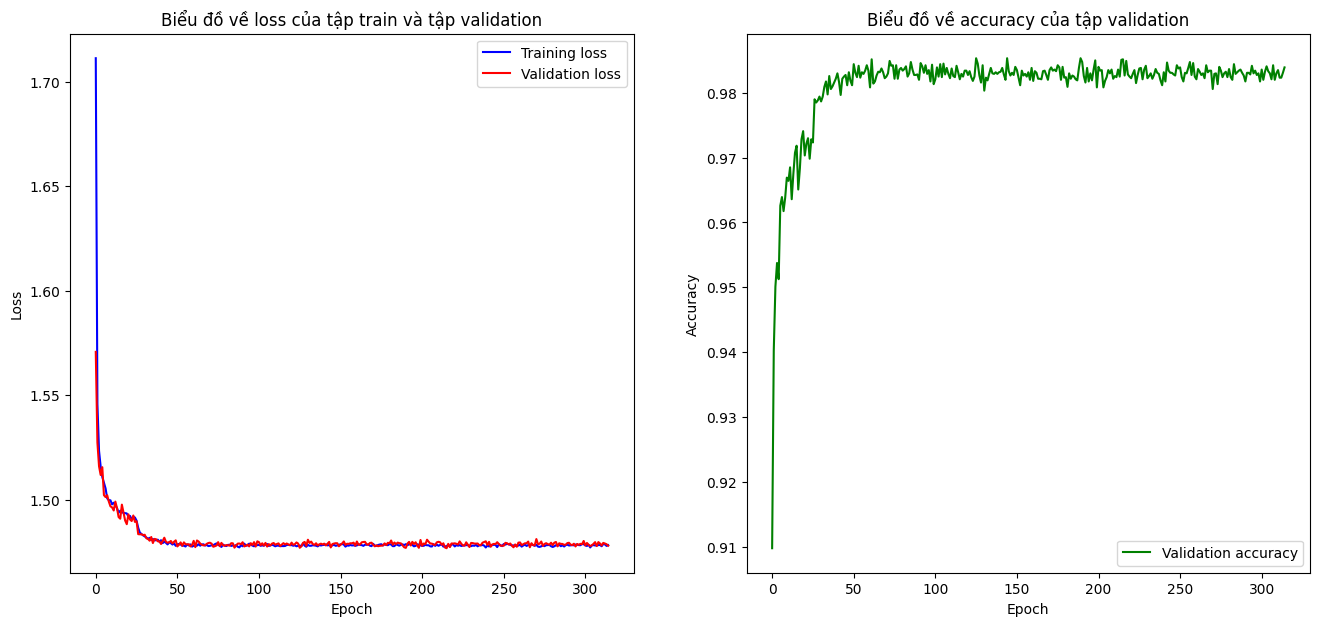

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].plot(trainloss_list, label='Training loss', color='blue')
axes[0].plot(valloss_list, label='Validation loss', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Biểu đồ về loss của tập train và tập validation')
axes[0].legend()

axes[1].plot(valaccuracy_list, label='Validation accuracy', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')  
axes[1].set_title('Biểu đồ về accuracy của tập validation')
axes[1].legend()

plt.show()